In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter
from glob import glob

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam



In [13]:
def load_signals_from_folder(folder_path, label_path):
    signal_files = sorted(glob(os.path.join(folder_path, "signal_*.npy")))
    if not signal_files:
        raise FileNotFoundError("No signal_*.npy files found in folder.")
    
    print(f"📁 Found {len(signal_files)} signal files.")
    X = np.array([np.load(f) for f in signal_files])
    y = np.load(label_path)
    return X, y


In [14]:
def augment_each_class(X, y, target_per_class=500):
    X_aug, y_aug = [], []
    for label in np.unique(y):
        class_signals = X[y == label]
        current_count = len(class_signals)
        needed = target_per_class - current_count
        augmented = []

        while len(augmented) < needed:
            for sig in class_signals:
                aug_sig = sig.copy()
                if random.random() < 0.5:
                    aug_sig = aug_sig[::-1]
                augmented.append(aug_sig)
                if len(augmented) >= needed:
                    break

        all_signals = np.concatenate([class_signals, np.array(augmented)])
        labels = np.full(target_per_class, label)
        X_aug.append(all_signals)
        y_aug.append(labels)

    return np.concatenate(X_aug), np.concatenate(y_aug)


In [15]:
def build_dense_model(input_shape, num_classes):
    model = Sequential([
        Dense(64, input_shape=(input_shape,), activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [6]:
folder_path = r"C:\Users\faizan\ECG_detection\cleaned_signals"
label_path = os.path.join(folder_path, "labels.npy")

# Load dataset
X, y = load_signals_from_folder(folder_path, label_path)
print(f"✅ Loaded signals: {X.shape}, labels: {y.shape}")

# Augment to balance
X, y = augment_each_class(X, y, target_per_class=500)
print(f"🔁 After augmentation: {X.shape}")
print("📊 Class distribution:", Counter(y))

# Normalize
X = (X - np.mean(X, axis=1, keepdims=True)) / (np.std(X, axis=1, keepdims=True) + 1e-8)


📁 Found 222 signal files.
✅ Loaded signals: (222, 5000), labels: (222,)
🔁 After augmentation: (1500, 5000)
📊 Class distribution: Counter({np.int64(0): 500, np.int64(1): 500, np.int64(2): 500})


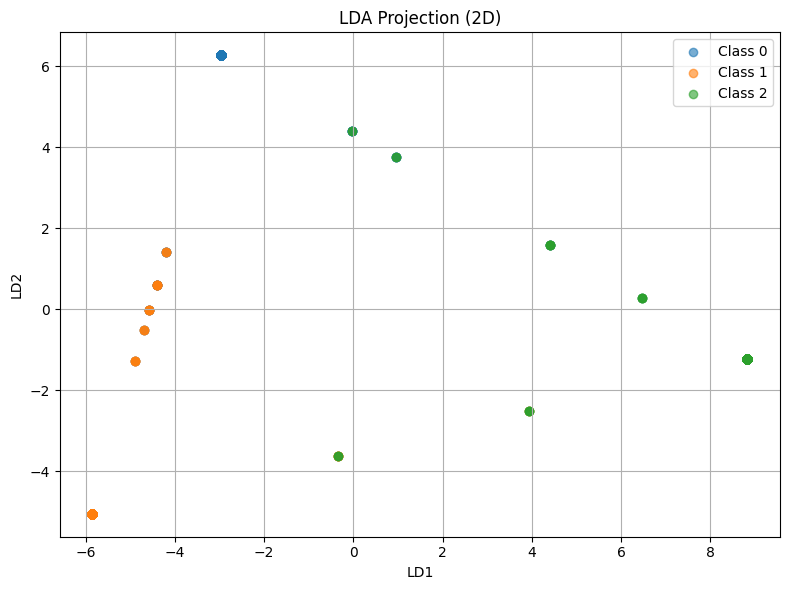

In [7]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, y)

# Visualize 2D projection
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    plt.scatter(X_lda[y == label, 0], X_lda[y == label, 1], label=f'Class {label}', alpha=0.6)
plt.legend()
plt.title("LDA Projection (2D)")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.grid(True)
plt.tight_layout()
plt.show()


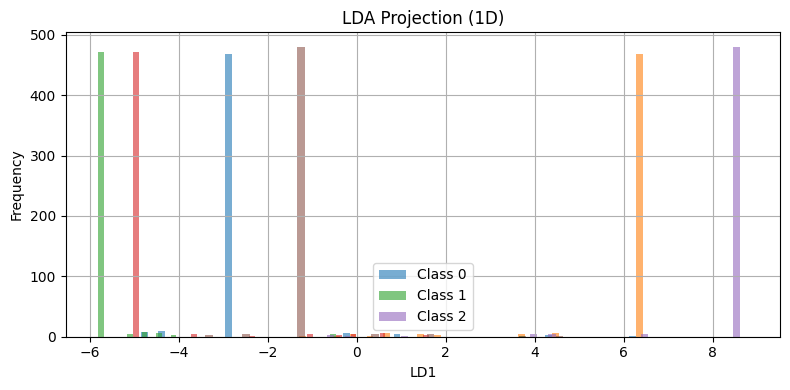

In [16]:
# Visualize 1D LDA Projection as histograms
plt.figure(figsize=(8, 4))

for label in np.unique(y):
    plt.hist(X_lda[y == label], bins=30, alpha=0.6, label=f'Class {label}')

plt.title("LDA Projection (1D)")
plt.xlabel("LD1")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, stratify=y, random_state=42)
y_train_cat = to_categorical(y_train, 3)
y_test_cat = to_categorical(y_test, 3)

# Build & train model
model = build_dense_model(input_shape=X_train.shape[1], num_classes=3)
history = model.fit(X_train, y_train_cat, epochs=30, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/30


C:\Users\faizan\anaconda3\envs\tfenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5592 - loss: 0.9501 - val_accuracy: 0.9917 - val_loss: 0.1278
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9567 - loss: 0.1902 - val_accuracy: 0.9833 - val_loss: 0.0360
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9714 - loss: 0.0984 - val_accuracy: 0.9833 - val_loss: 0.0309
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9760 - loss: 0.0874 - val_accuracy: 0.9833 - val_loss: 0.0311
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9793 - loss: 0.0906 - val_accuracy: 0.9833 - val_loss: 0.0312
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9864 - loss: 0.0655 - val_accuracy: 0.9833 - val_loss: 0.0329
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9760 - loss: 0.0672 - val_accuracy: 0.9833 - val_loss: 0.0329
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9861 - loss: 0.0551 - val_accuracy: 0.9833 - val_loss: 0.0334
E

In [9]:
model_save_path = os.path.join(folder_path, "lda_dense_model.h5")
model.save(model_save_path)
print(f"✅ Model saved to: {model_save_path}")


✅ Model saved to: C:\Users\faizan\ECG_detection\cleaned_signals\lda_dense_model.h5


In [10]:
# Predict and evaluate
y_pred = np.argmax(model.predict(X_test), axis=1)

print("\n🧾 Classification Report:")
print(classification_report(y_test, y_pred))
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

🧾 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       100
           1       0.97      0.98      0.98       100
           2       1.00      0.98      0.99       100

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300

✅ Accuracy: 98.00%


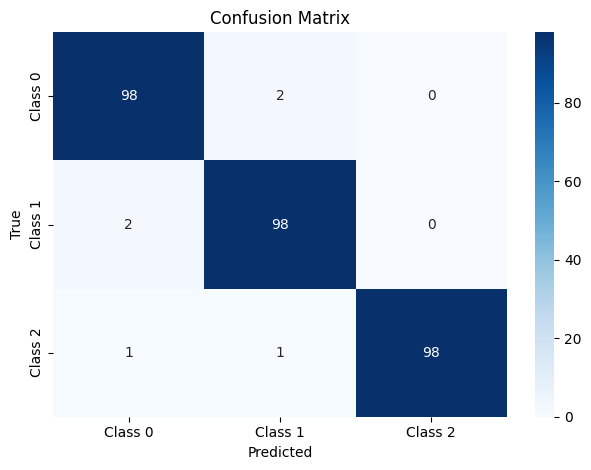

In [17]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
